In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models

2024-06-21 15:56:29.948937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 15:56:31.277198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-21 15:56:31.277347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-21 15:56:31.277365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [5]:
import pickle
import json

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
with open('../datasets-ood/chem/train.csv', 'r') as f:
  dataX = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('../datasets-ood/chem/train.csv', 'r') as f:
  dataY = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

X = dataX
Y = dataY

In [8]:
with open('../datasets-ood/chem/val_ood.csv', 'r') as f:
  external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('../datasets-ood/chem/val_ood.csv', 'r') as f:
  external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])


In [9]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
# sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

In [10]:
print(X.shape)
print(Y.shape)

(5997, 1024)
(5997,)


In [11]:
class RandFeats:
  # def __init__(self, sigma_rot, d, D=196):
  def __init__(self, sigma_rot, d, D=128):

    # self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot]
    self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X, xD):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(X[rprm[:100], :], X[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X.shape[1], int(X.shape[1]*xD))

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [12]:
class RandFeats:
  # def __init__(self, sigma_rot, d, D=196):
  def __init__(self, sigma_rot, X, d, D=128):

    # self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot]
    self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot/2, sigma_rot/4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)
    self.Ws = self.sample_features(X)
    
  def sample_features(self, X, ):
    L = int(0.3 * len(X))
    M = self.Ws.shape[0] * self.Ws.shape[2]
    # N = np.random.choice(M, int(M/100), replace=False)
    N = int(M/100)+10
    phi_Xt = tf.transpose(self.get_features(X[np.random.choice(len(X), L)])) / np.sqrt(L)
    phi_phi_T = phi_Xt @ tf.transpose(phi_Xt)
    mu = np.power(10, 0)
    diag = np.diag(phi_phi_T @ np.linalg.inv(phi_phi_T + mu))
    diag = diag / np.sum(diag)
    print(M, len(diag)//2, phi_Xt.shape, self.Ws.shape)
    print("Diag", M, diag, np.argsort(diag)[-N])
    k, N, D = self.Ws.shape
    diag = diag[:len(diag)//2] + diag[len(diag)//2:]
    w_indices = np.unique(np.argsort(diag)[-N:])
    _Ws = np.reshape(np.transpose(self.Ws, [1, 2, 0]), (N, -1))[:, w_indices]
    return np.transpose(np.reshape(_Ws, (N, -1, 1)), [2, 0, 1])

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    # phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.transpose(phis, [1, 2, 0])[:, None, :, :]  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X, xD):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(X[rprm[:100], :], X[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X, X.shape[1], int(X.shape[1]*xD))

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [13]:
Dx = [1.5, 2, 4, 8, 10, 16]

In [14]:
def get_rand_feats(X, model):
  """
  Args:
    X: N x d matrix of input features
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector

  Returns:
    Phis: N x D matrix of random features
  """
  # XWs = tf.matmul(X, Ws)
  # return tf.cos(XWs+bs)
  return model(X)

In [15]:
def linear_coefs(X, X_ids, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  # clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, Y)
  print(np.mean(X), np.mean(Y), "ASDASDADASD")
  clf = SVC(random_state=0, tol=1e-5, kernel='linear').fit(X, Y)
  # clf = LinearSVC(random_state=0, tol=1e-5).fit(X, Y)
  support = (clf.support_, clf.n_support_)

  def get_supp(support):
      supps_, n_supps_ = support
      supps_0 = supps_[:n_supps_[0]]
      supps_1 = supps_[n_supps_[0]:]
      return X_ids[supps_0], X_ids[supps_1]

  support = get_supp(support)
    
  # clf = LogisticRegression(random_state=0).fit(X, Y)
  print(clf.score(X, Y))
  wgts = np.hstack((clf.intercept_[:,None], clf.coef_))
  print(wgts.shape)
  prd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.T)) > 0.5) *1.0
  # print(np.mean(prd[:, 0]==Y))
  return wgts, None
  # beta = tf.linalg.solve(tf.matmul(tf.transpose(X),X), tf.matmul(tf.transpose(X), Y[:, None]))
  # return beta

In [16]:
def project_and_filter(X, dir, percentile=75):
  projs = np.dot(X, dir)
  thresh = np.percentile(projs, 100 - percentile)
  filtered_idxs = projs >= thresh
  return X[filtered_idxs], filtered_idxs

In [19]:
def get_models(X, Y, pca_projs, dirs, model, percentile=75):
  #X_subsets = []
  #data_ids = []
  #Y_subsets = []
  betas = []
  supps = []
  i = 0
  for dir in dirs: # TODO: Vectorize
    if i % 25 == 0: print(f"Step {i}")
    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    print(X_sub.shape, X_ids.shape)
    # print((X_sub@pca_projs).shape)
    print("CHECKKKKK ", np.mean(get_rand_feats(X_sub@pca_projs, model)))
    print(np.sum(X), np.sum(X@pca_projs))
    beta, supp = linear_coefs(get_rand_feats(X_sub@pca_projs, model), np.argwhere(X_ids), Y_sub)
    print("Dir", dir)
    print("Beta", beta)
    # beta = linear_coefs(X_sub, Y_sub)

    #X_subsets.append(X_sub)
    #data_ids.append(X_ids)
    #Y_subsets.append(Y_sub)
    betas.append(beta)
    supps.append(supp)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

  # cant do this because subsets of variable sizes
  #X_subsets = np.array(X_subsets)
  #data_ids = np.array(data_ids)
  #Y_subsets = np.array(Y_subsets)
  betas = np.array(betas)

  return betas, supps
  #return X_subsets, data_ids, Y_subsets, betas

In [20]:
X.shape

(5997, 1024)

In [21]:
np.sum(X)

-0.0052576065

In [44]:
with tf.device('gpu:1'):
    s, u, v = tf.linalg.svd(X)

In [36]:
print(s[1])

tf.Tensor(232.08453, shape=(), dtype=float32)


In [37]:
# dims = [0.05, 0.25, 0.3, 0.4, 0.8]
dims = [0.05, 0.2, 0.3, 0.4, 0.8]
pca_projs = v[:, :int(X.shape[-1]*dims[1])]

In [38]:
np.save('pca.npy', pca_projs)

In [43]:
np.sum(pca_projs), print("ONENNN", np.sum(v))

ONENNN -24.82146


(0.08707595, None)

In [253]:
X.shape, pca_projs.shape
random_dirs = np.random.randn(N, d)

In [254]:
np.random.seed(74)
X_prjs = np.array(X@pca_projs)
# model = define_rand_feats(X_prjs, Dx[2])
model = define_rand_feats(X_prjs, 2)

N = 512    # ~ 8k
# N = 16    # ~ 8k
d = X.shape[-1]
random_dirs = np.random.randn(N, d) # Maybe do the random directions in the random feature space??? Feel like that makes more sense

random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)

#X_subsets, data_ids, Y_subsets, betas = get_models(X, Y, random_dirs, Ws, bs, percentile=33)
betas, supps = get_models(X, Y, pca_projs, random_dirs, model, percentile=20)

Step 0
(1200, 1024) (5997,)
CHECKKKKK  0.19985221
-0.0052576065 -0.00623703
0.19985221 0.545 ASDASDADASD
0.9966666666666667
(1, 4081)
Dir [ 0.04905563  0.03169993 -0.01668578 ... -0.02326956  0.02807696
  0.05754044]
Beta [[ 0.29058316  0.03562289 -0.00618984 ...  0.03539478 -0.0066337
   0.00280665]]
(1201, 1024) (5997,)
CHECKKKKK  0.18812044
-0.0052576065 -0.00623703
0.18812044 0.6053289 ASDASDADASD
0.9941715237302248
(1, 4081)
Dir [-0.05284877 -0.01113672  0.01344122 ... -0.01854731  0.02493274
 -0.03622702]
Beta [[ 0.04925948 -0.00100127  0.0172976  ... -0.01054612  0.00822153
   0.00358063]]
(1200, 1024) (5997,)
CHECKKKKK  0.19500722
-0.0052576065 -0.00623703
0.19500722 0.5775 ASDASDADASD
0.995
(1, 4081)
Dir [-0.00040978  0.04100408 -0.0269265  ... -0.0292302  -0.01387339
  0.0406016 ]
Beta [[ 0.44189246 -0.00574511 -0.04819742 ... -0.00822744  0.00855847
   0.00052637]]
(1200, 1024) (5997,)
CHECKKKKK  0.19672775
-0.0052576065 -0.00623703
0.19672775 0.46916667 ASDASDADASD
0.995
(1

KeyboardInterrupt: 

In [ ]:
# directional sampling
# pick direction and find beta
# find poor performing points' clusters means say at x+10, x+30 ... % data (x is what was trained on)
# add all those cluster mean directions to the random_dir set
# repeat 
# should improve accuracy since poor performing points get classified and also reduce number of betas required


In [36]:
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

nclusters = [1, 2, 3, 4, 5, 6, 7, 8, 9]
random_dirs = []
betas, supps = [], []
iters = 100
max_rand_dirs = 300
new_rand_dirs = np.random.randn(1, d)
num_rand_dirs = 0
for i in range(iters):
    if num_rand_dirs > max_rand_dirs:
        break
    new_rand_dirs = new_rand_dirs / np.linalg.norm(new_rand_dirs, axis=1, keepdims=True)
    new_rand_dirs = new_rand_dirs[np.random.choice(len(new_rand_dirs), size=min(len(new_rand_dirs), 50), replace=False, p=None)]
    random_dirs.append(new_rand_dirs)
    num_rand_dirs += len(new_rand_dirs)
    #print(new_rand_dirs.shape)
    print("New dirs: ", len(new_rand_dirs))
    
    _betas, _supps = get_models(X, Y, pca_projs, new_rand_dirs, model, percentile=20)
    betas.append(_betas)
    supps += _supps
    _new_rand_dirs = []
    for _dir, _beta in zip(new_rand_dirs, _betas):
        for ix, prcnt in enumerate(range(25, 100, 20)):
            X_sub, X_ids = project_and_filter(X, _dir, prcnt)
            Y_sub = Y[X_ids]
            _beta = tf.squeeze(_beta)
            _dir = tf.constant(_dir)
            prd = softmax(get_rand_feats(X_sub@pca_projs, model), _beta)

            incrct = np.where(prd != Y_sub)
            # print(len(prd), len(Y_sub), get_rand_feats(X_sub@pca_projs, model).shape, _beta.shape, prd)
            incrct_X = get_rand_feats(X_sub[incrct]@pca_projs, model)
            if len(incrct_X) < 20:
                continue
            kmeans = KMeans(n_clusters=nclusters[ix], random_state=0, n_init="auto").fit(incrct_X)
            mp = kmeans.cluster_centers_
            neigh = NearestNeighbors(n_neighbors=5)
            neigh.fit(incrct_X)

            n_ind = neigh.kneighbors(mp, 3, return_distance=False)
            nngr_id = [_n_ind[np.random.choice(3, 1)[0]] for _n_ind in n_ind]

            _new_rand_dirs.append(X_sub[incrct][nngr_id] + np.random.randn(*X_sub[incrct][nngr_id].shape)*0.1)
    new_rand_dirs = np.concatenate(_new_rand_dirs, axis=0)
    print("Total dirs: ", num_rand_dirs)

betas = np.concatenate(betas, axis=0)
random_dirs = np.concatenate(random_dirs, axis=0)

New dirs:  1
Step 0
(1200, 1024) (5997,)
0.9966666666666667
(1, 2449)
Total dirs:  1
New dirs:  10
Step 0
(1200, 1024) (5997,)
0.9975
(1, 2449)
(1200, 1024) (5997,)
0.9933333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9966666666666667
(1, 2449)
(1200, 1024) (5997,)
0.9983333333333333
(1, 2449)
(1200, 1024) (5997,)
0.995
(1, 2449)
(1200, 1024) (5997,)
0.9925
(1, 2449)
(1200, 1024) (5997,)
0.995
(1, 2449)
Done
(1200, 1024) (5997,)
0.9966666666666667
(1, 2449)
Total dirs:  11
New dirs:  50
Step 0
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.995
(1, 2449)
(1200, 1024) (5997,)
0.9966666666666667
(1, 2449)
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9958333333333333
(1, 2449)
(1200, 1024) (5997,)
0.9966666666666667
(1, 2449)
(1200, 1024) (5997,)
0.9975
(1, 2449)
(1200, 1024) (5997,)
0.9958

In [101]:
X_sub.shape

(5697, 1024)

In [156]:
def check_simi(a, b):
    return tf.losses.CosineSimilarity()(a, b)    

check_simi(betas[2], betas[1])

<tf.Tensor: shape=(), dtype=float64, numpy=-0.1706338411346348>

In [147]:
# np.save('random_dirs-chem2.npy', random_dirs)
# np.save('betas-chem2.npy', betas)
# np.save('Ws-chem2.npy', model.Ws)

np.save('chem-random_dirs-svm-best1.npy', random_dirs)
np.save('chem-betas-svm-best1.npy', betas)
np.save('chem-Ws-svm-best1.npy', model.Ws)

np.save('chem-pca_projs_data-svm-best1.npy', pca_projs)
np.save('chem-pca_projs_dir-svm-best1.npy', np.identity(X.shape[-1]))


In [77]:
import pickle
# with open("chem-supps-svm.npy", "wb") as fp:
#     pickle.dump(supps, fp)

with open("chem-supps-svm-best.npy", "rb") as fp:
    supps_b = pickle.load(fp)

In [271]:
random_dirs = tf.constant(np.load('./random_dirs-chem2.npy'))
betas = tf.squeeze(tf.constant(np.load('./betas-chem2.npy')))
model = define_rand_feats(X_prjs, 2)
model.Ws = tf.constant(np.load('./Ws-chem2.npy'))

In [79]:


random_dirs = tf.constant(np.load('./chem-random_dirs-svm.npy'))
betas = tf.squeeze(tf.constant(np.load('./chem-betas-svm.npy')))
# model = define_rand_feats(X, 1.5)
model = define_rand_feats(X, 2)
model.Ws = tf.constant(np.load('./chem-Ws-svm.npy'))

In [36]:
np.allclose(random_dirs1, random_dirs)

NameError: name 'random_dirs1' is not defined

In [26]:
np.sum(random_dirs1 - random_dirs)

NameError: name 'random_dirs1' is not defined

In [138]:
betas = tf.squeeze(betas)
print(betas.shape)
random_dirs = tf.constant(random_dirs)
print(random_dirs.shape)

(512, 4081)
(512, 1024)


In [145]:
# var = tf.math.reduce_variance(betas, axis=0)
# mean_var = tf.reduce_mean(var)
# print(var)

var = tf.math.reduce_variance(betas, axis=0)
mean_var = tf.reduce_mean(var)
print("Min var: ", np.min(var), "Max var: ", np.max(var), "Mean var: ", mean_var)

Min var:  2.082857549308727e-06 Max var:  0.09755260247485288 Mean var:  tf.Tensor(0.00026783628375975856, shape=(), dtype=float64)


In [165]:
sample = 1
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

def softmax_prob(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) ) *1.0
  return sd[:]

X_sub, X_ids = project_and_filter(X, random_dirs[sample], 25)
Y_sub = Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.932

In [166]:
prd1 = prd

In [167]:
ex_X = tf.cast(external_X, tf.float32)
ex_Y = external_Y
ex_X = (ex_X-mu_x)/sigma_x


In [168]:

X_sub, X_ids = project_and_filter(ex_X, random_dirs[10], 25)
Y_sub = ex_Y[X_ids]
prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.5446808510638298

In [39]:
perds = np.zeros((ex_X.shape[0],))
cnt = np.zeros((ex_X.shape[0],))
print(perds.shape)
for sm in range(512):
    X_sub, X_ids = project_and_filter(ex_X, random_dirs[sm], 15)
    Y_sub = ex_Y[X_ids]
    prd = softmax_prob(get_rand_feats(X_sub@pca_projs, model), betas[sm])
    # print(prd.shape, X_ids, ex_X.shape)
    perds[X_ids] += prd
    cnt[X_ids] += 1


(937,)


In [72]:
zer_ids = np.argwhere(cnt!=0)
veX = perds[zer_ids]
veX /= cnt[zer_ids]
((veX>0.5)==Y_sub).mean()

0.501992552056132

In [50]:
print((np.mean(tf.stack(perds, axis=0), axis=0)==Y_sub).mean())

0.0


In [78]:
supps_0, supps_1 = supps_b[sample]
supps_0.shape, supps_1

TypeError: cannot unpack non-iterable NoneType object

In [54]:
suppvs_0 = X[supps_0.reshape((-1,))]
suppvs_1 = X[supps_1.reshape((-1,))]
y_supp_0 = Y[supps_0.reshape((-1,))]
y_supp_1 = Y[supps_1.reshape((-1,))]
suppvs_0

array([[-0.04052026, -0.29764882, -0.08170752, ..., -0.04052026,
        -0.06053026, -0.03134901],
       [-0.04052026, -0.29764882, -0.08170752, ..., -0.04052026,
        -0.06053026, -0.03134901],
       [-0.04052026,  0.7023512 , -0.08170752, ..., -0.04052026,
        -0.06053026, -0.03134901],
       ...,
       [-0.04052026, -0.29764882, -0.08170752, ..., -0.04052026,
        -0.06053026, -0.03134901],
       [-0.04052026, -0.29764882,  0.91829246, ..., -0.04052026,
        -0.06053026, -0.03134901],
       [-0.04052026, -0.29764882,  0.91829246, ..., -0.04052026,
        -0.06053026, -0.03134901]], dtype=float32)

In [58]:
suppvs_0.shape

(381, 1024)

In [60]:
def get_margin(X, wgts):
  sd = (np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T) * 1.0
  return sd[:]

def loss_2(labels, margins):
    l = 2*labels - 1
    return tf.reduce_sum(tf.reduce_mean(tf.nn.relu(-margins * l), axis=0))

get_rand_feats(tf.cast(suppvs_0@pca_projs, dtype=tf.float32), model).shape, betas[sample].shape
print(get_margin(get_rand_feats(tf.cast(suppvs_0@pca_projs, dtype=tf.float32), model), betas[sample]), y_supp_0)
# loss_2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print(loss_2(y_supp_0[:len(suppvs_0)], get_margin(get_rand_feats(tf.cast(suppvs_0@pca_projs, dtype=tf.float32), model), betas[sample]*3)))

[-0.99999557 -0.99999864 -1.00000015 -1.00000274 -0.99999844 -1.00000071
 -1.00000048 -0.99999712 -0.99999474 -1.00000096 -0.99999895 -1.0000031
 -1.00000271 -0.99999792 -0.99999714 -0.99999876 -0.99999873 -0.99999996
 -1.00000344 -0.99999897 -0.9999988  -1.00000246 -0.99999731 -0.99999866
 -0.99999845 -0.99999905 -1.00000161 -0.9999993  -0.99999992 -1.00000107
 -1.0000001  -0.99999536 -0.99999485 -0.99999945 -1.00000243 -0.99999581
 -0.99999901 -1.00000531 -1.         -0.9999974  -0.99999841 -0.99999726
 -1.0000001  -1.00000406 -1.00000235 -1.00000085 -1.00000044 -1.00000429
 -1.00000434 -1.00000024 -1.00000118 -0.999996   -0.99999972 -0.9999999
 -1.00000058 -0.99999397 -0.99999636 -1.00000286 -1.00000797 -1.00000088
 -1.00000028 -1.00000142 -1.0000043  -0.99999972 -0.99999621 -1.00000086
 -1.00000302 -1.00000322 -1.00000138 -1.00000425 -0.99999989 -1.0000025
 -1.00000054 -0.99999991 -0.9999996  -0.99999743 -0.99999847 -1.00000061
 -1.00000114 -1.00000165 -1.00000441 -0.99999933 -0.99

## Should test Betas performance first

In [106]:
from tensorflow.keras import layers, models

beta_dim = betas.shape[-1]
input_dir_dim = random_dirs.shape[-1]
latent_dim = 64

# Encoder
# beta_input = layers.Input(shape=(beta_dim,))
dir_input = layers.Input(shape=(input_dir_dim,))
encoder_inputs = layers.Concatenate()([dir_input])
# x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
# x = layers.Dense(256, activation=tf.nn.elu)(x)
# x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(64, activation=tf.nn.elu)(x)
x = layers.Dense(latent_dim, activation=tf.nn.elu)(x)
# z_mean = layers.Dense(latent_dim)(x)
# z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

# z = layers.Lambda(sampling)([z_mean, z_log_var])
z = layers.Dense(latent_dim)(x)


### Using direction in Decoder is weird
### Likely just train VAE solely on betas with directions


# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
# decoder_dir_input = layers.Input(shape=(input_dir_dim,))
decoder_inputs = layers.Concatenate()([latent_inputs])
x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(512, activation=tf.nn.elu)(x)
# x = layers.Dense(64, activation=tf.nn.elu)(x)
# x = layers.Dense(256, activation=tf.nn.elu)(decoder_inputs)
# x = layers.Dense(512, activation=tf.nn.elu)(x)
beta_output = layers.Dense(beta_dim)(x)

# Instantiate model
encoder = models.Model([dir_input], z, name="encoder")
decoder = models.Model([latent_inputs], beta_output, name="decoder")

# VAE
outputs = decoder([encoder([dir_input])])
vae = models.Model([dir_input], outputs, name="autoenc")
vae.encoder = encoder
vae.decoder = decoder

In [101]:
def get_margin_batched(supp_vs, wgts):
  sd = (tf.concat([tf.ones((*supp_vs.shape[:-1], 1)), supp_vs], axis=-1) @ wgts[:, :, None]) * 1.0
  return sd[:]

In [29]:
ots = vae((betas[:1], random_dirs[:1]))

In [30]:
#def vae_loss(inputs, outputs, z_mean, z_log_var, reg=0.002):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
#  intercp_loss = tf.reduce_mean(tf.abs(tf.cast(inputs[:, :1], dtype=tf.float32) - outputs[:, :1]))
#  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs[:, 1:], dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs[:, 1:], axis=-1)[0], axis=-1))
#  kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
#  total_loss = recon_loss + intercp_loss + reg * kl_loss
#  return total_loss, recon_loss, intercp_loss, kl_loss

In [107]:
def vae_loss(inputs, outputs, supp_vs, supp_ys, reg=1.0, regr=1.0):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs, dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs, axis=-1)[0], axis=-1))
  # print(supp_vs.shape, outputs.shape)
  supp_margins = get_margin_batched(supp_vs, outputs)
  supp_loss = loss_2(supp_ys, supp_margins)
  # print(supp_ys[0][30:], supp_margins[0][30:])
  # print(supp_margins.shape, supp_ys.shape)
  # kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
  total_loss = reg * recon_loss + regr * supp_loss
  return total_loss, reg*recon_loss, regr*supp_loss

In [31]:
vae_loss(betas[:1], ots[:1], tf.ones((1, 32)), tf.ones((1, 32)))

(<tf.Tensor: shape=(), dtype=float32, numpy=1.1964941>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0429045>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09860455>,
 <tf.Tensor: shape=(), dtype=float32, numpy=27.492508>)

In [108]:
opt = tf.keras.optimizers.Adam()


def train_step(model, inputs, dir_inputs, supp_vs, supp_ys, alpha, ralpha=1.0):
  with tf.GradientTape() as tape:
    z = model.encoder([dir_inputs])
    outputs = model.decoder([z])
    total_loss, recon_loss, supp_loss = vae_loss(inputs, outputs, supp_vs, supp_ys, alpha, ralpha)
  grads = tape.gradient(total_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, recon_loss, supp_loss

In [33]:
train_step(vae, betas[:32], random_dirs[:32])

2024-04-29 19:41:59.480502: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1576b9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 19:41:59.480542: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-04-29 19:41:59.486897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 19:41:59.594610: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-29 19:41:59.674717: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(<tf.Tensor: shape=(), dtype=float32, numpy=1.0526553>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.999847>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.051767856>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52023363>)

In [80]:
X[supps_0.reshape((-1,))] @ pca_projs

<tf.Tensor: shape=(381, 204), dtype=float32, numpy=
array([[-9.73291   , -0.08359981,  4.8285213 , ..., -0.418212  ,
         0.04979858, -0.38527712],
       [-1.4835713 ,  1.0568206 ,  2.5018466 , ..., -0.06100272,
         0.1693849 , -0.38147366],
       [-7.0123835 , -9.252638  , -1.9807861 , ...,  0.136215  ,
         0.12370304,  0.3105353 ],
       ...,
       [-4.699366  ,  2.6286366 , -1.7926993 , ..., -0.3052967 ,
         0.18089612, -0.36616707],
       [-1.7197244 ,  1.9622226 ,  2.9822083 , ..., -0.33606544,
        -0.01879999,  0.30114657],
       [-1.7413275 ,  1.9585967 ,  3.080233  , ..., -0.47907415,
         0.07559836,  0.45271814]], dtype=float32)>

In [104]:
def batch(X, betas, dirs, supps, batch_size, support_batch_size):
  num_samples = betas.shape[0]
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  betas = np.array(betas)[indices]
  dirs = np.array(dirs)[indices]
  supps_ = [supps[i] for i in indices]
  supps_ = np.array([np.stack([i[np.random.choice(len(i), support_batch_size)],
                     j[np.random.choice(len(j), support_batch_size)]], axis=0) for i, j in supps_])
  def supp_get_vs(_supps):
      supps_0, supps_1 = np.transpose(_supps, (1, 0, 2, 3))
      suppvs_0 = X[supps_0.reshape((-1,))] @ pca_projs
      suppvs_1 = X[supps_1.reshape((-1,))] @ pca_projs
      suppvs_0 = tf.reshape(get_rand_feats(tf.cast(suppvs_0, dtype=tf.float32), model), (batch_size, support_batch_size, -1))
      suppvs_1 = tf.reshape(get_rand_feats(tf.cast(suppvs_1, dtype=tf.float32), model), (batch_size, support_batch_size, -1))
      y_supp_0 = Y[supps_0.reshape((-1,))].reshape((batch_size, support_batch_size, -1))
      y_supp_1 = Y[supps_1.reshape((-1,))].reshape((batch_size, support_batch_size, -1))
      return np.concatenate([suppvs_0, suppvs_1], axis=1), np.concatenate([y_supp_0, y_supp_1], axis=1)
  for i in range(0, betas.shape[0], batch_size):
    yield betas[i:i+batch_size], dirs[i:i+batch_size], *supp_get_vs(supps_[i:i+batch_size])

In [35]:
batch(betas, random_dirs, 2)

<generator object batch at 0x7fb77c7be890>

In [ ]:
epochs = 2000
fine_tune_epochs = 3
batch_size = 32
support_batch_size = 300
alpha0 = 4
nalpha = alpha0
for i in range(epochs):
  nalpha = min(nalpha * 1.02, 60)
  print(f"Epoch {i}")
  for step, (batch_betas, batch_dirs, supp_vs, supp_ys) in enumerate(batch(X, betas, random_dirs, supps_b, batch_size, support_batch_size)):
    # print(supp_vs.shape, supp_ys.shape)
    loss_vals = train_step(vae, batch_betas, batch_dirs, supp_vs, supp_ys, 1.0, 0.0)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon loss = {loss_vals[1].numpy()}, supp loss = {loss_vals[2].numpy()}")
    for j in range(fine_tune_epochs):
        loss_vals = train_step(vae, batch_betas, tf.linalg.normalize(batch_dirs + np.random.randn(*batch_dirs.shape)*0.1, axis=-1)[0], supp_vs, supp_ys, 1.0, 0.0)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon loss = {loss_vals[1].numpy()}, supp loss = {loss_vals[2].numpy()}")
  print()

Epoch 0
Step 0: loss = 1.0042555332183838, recon loss = 1.0042555332183838, supp loss = 0.0
Step 0: loss = 0.6852933168411255, recon loss = 0.6852933168411255, supp loss = 0.0

Epoch 1
Step 0: loss = 0.5890307426452637, recon loss = 0.5890307426452637, supp loss = 0.0
Step 0: loss = 0.5855118036270142, recon loss = 0.5855118036270142, supp loss = 0.0

Epoch 2
Step 0: loss = 0.5907216668128967, recon loss = 0.5907216668128967, supp loss = 0.0
Step 0: loss = 0.5872777700424194, recon loss = 0.5872777700424194, supp loss = 0.0

Epoch 3
Step 0: loss = 0.5776413083076477, recon loss = 0.5776413083076477, supp loss = 0.0
Step 0: loss = 0.5796323418617249, recon loss = 0.5796323418617249, supp loss = 0.0

Epoch 4
Step 0: loss = 0.5833013653755188, recon loss = 0.5833013653755188, supp loss = 0.0
Step 0: loss = 0.5857218503952026, recon loss = 0.5857218503952026, supp loss = 0.0

Epoch 5
Step 0: loss = 0.578827440738678, recon loss = 0.578827440738678, supp loss = 0.0
Step 0: loss = 0.58076572

In [ ]:
vae.save_weights('./my_checkpoint/chekpont')

In [ ]:
vae.load_weights('./my_checkpoint/chekpont')

In [ ]:
# !zip -r my_checkpoint.zip my_checkpoint/
!unzip chem-checkpoint.zip

Archive:  chem-checkpoint.zip
   creating: my_checkpoint/
  inflating: my_checkpoint/chekpont.index  
  inflating: my_checkpoint/.data-00000-of-00001  
  inflating: my_checkpoint/checkpoint  
  inflating: my_checkpoint/chekpont.data-00000-of-00001  
  inflating: my_checkpoint/.index    


In [38]:
drawn_random_dirs = np.random.randn(50_000, d)

In [54]:
# Dont really think this works, since the latent space should be conditioned on the direction
# Just to try something
# Likely better to just have VAE solely on betas w/o directions

def posterior_sampling(model, betas, random_dirs, num_samples=1):
  zm, zlv, z = model.encoder((betas, random_dirs))
  if num_samples == 1:
      return model.decoder((z, random_dirs))
  else:
      samples = [sampling((zm, zlv)) for _ in range(num_samples)]
      return tf.concat([model.decoder((sm, random_dirs))[:, None, :] for sm in samples], axis=1)

def generate_new_betas(model, num_samples=1):
  random_dirs1 = np.random.randn(num_samples, d)
  random_dirs2 = np.random.randn(num_samples, d)
  random_dirs1 = random_dirs1 / np.linalg.norm(random_dirs1, axis=1, keepdims=True)
  random_dirs1 = tf.constant(random_dirs1)
  random_dirs2 = random_dirs2 / np.linalg.norm(random_dirs2, axis=1, keepdims=True)
  random_dirs2 = tf.constant(random_dirs2)
  latent_samples1 = tf.random.normal(shape=(num_samples, latent_dim))    
  latent_samples2 = tf.random.normal(shape=(num_samples, latent_dim))
  return model.decoder([latent_samples1, random_dirs1]), random_dirs1, model.decoder([latent_samples2, random_dirs1])

In [55]:
drawn_betas, dir1, drawn_betas2 = generate_new_betas(vae, 50_000)
# drawn_betas = posterior_sampling(vae, betas, np.random.randn(512, d), 1)
# drawn_betas = posterior_sampling(vae, betas, random_dirs, 1)
# drawn_betas = posterior_sampling(vae, betas, random_dirs, 100)
# generate_new_betas

NameError: name 'vae' is not defined

In [108]:
sample = 200
X_sub, X_ids = project_and_filter(X, random_dirs[sample], 40)
Y_sub = Y[X_ids]
prd1 = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

In [109]:
X_sub, X_ids = project_and_filter(X, random_dirs[sample], 40)
Y_sub = Y[X_ids]
# prd2 = softmax(get_rand_feats(X_sub@pca_projs, model), drawn_betas[sample][0])
prd2 = softmax(get_rand_feats(X_sub@pca_projs, model), drawn_betas[sample])

In [110]:
drawn_betas[0], betas[0]

(<tf.Tensor: shape=(4081,), dtype=float32, numpy=
 array([-0.00631047,  0.12106761,  0.46212596, ...,  0.47387064,
        -0.281489  , -0.05550657], dtype=float32)>,
 <tf.Tensor: shape=(4081,), dtype=float64, numpy=
 array([ 0.00832155,  0.00116945,  0.10095101, ...,  0.12449417,
        -0.06915902, -0.01289894])>)

In [111]:
# check agreement between vae and training samples
from sklearn.metrics import jaccard_score
def agreement(y_pred1, y_pred2, y_true):
    tp1 = np.float32(y_pred1==1) * np.float32(y_true==1)
    fp1 = np.float32(y_pred1==1) * np.float32(y_true==0)
    tn1 = np.float32(y_pred1==0) * np.float32(y_true==0)
    fn1 = np.float32(y_pred1==0) * np.float32(y_true==1)

    tp2 = np.float32(y_pred2==1) * np.float32(y_true==1)
    fp2 = np.float32(y_pred2==1) * np.float32(y_true==0)
    tn2 = np.float32(y_pred2==0) * np.float32(y_true==0)
    fn2 = np.float32(y_pred2==0) * np.float32(y_true==1)
    print(np.sum(tp1)/len(tp1), np.sum(fp1)/len(tp1), np.sum(tn1)/len(tp1), np.sum(fn1)/len(tp1))
    print(np.sum(tp2)/len(tp1), np.sum(fp2)/len(tp1), np.sum(tn2)/len(tp1), np.sum(fn2)/len(tp1))
    print(np.sum(fp1==fp2)/len(tp1), np.sum(fn1==fn2)/len(tp1))
    return jaccard_score(tp1, tp2), jaccard_score(fp1, fp2), jaccard_score(tn1, tn2), jaccard_score(fn1, fn2)

In [112]:
agreement(prd1, prd2, Y_sub)

0.5735723218007504 0.0029178824510212586 0.4210087536473531 0.0025010421008753647
0.5731554814506045 0.0025010421008753647 0.42142559399749896 0.0029178824510212586
0.9979157982492706 0.9979157982492706


(0.9963715529753265,
 0.4444444444444444,
 0.9950641658440277,
 0.4444444444444444)

In [40]:
drawn_betas.shape

TensorShape([512, 10, 4081])

In [68]:
inps= betas
oups = drawn_betas
tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(tf.expand_dims(inps, axis=1)[:, :, 1:], dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(oups[:, :, 1:], axis=-1)[0], axis=-1))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0054231044>

In [69]:
tf.reduce_mean(tf.abs(tf.cast(tf.expand_dims(inps, axis=1)[:, :, :1], dtype=tf.float32)-oups[:, :, :1]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.012491584>

In [226]:
drawn_betas1[0], betas[0]

(<tf.Tensor: shape=(4081,), dtype=float32, numpy=
 array([ 0.01558006,  0.08848727,  0.02163708, ...,  0.32644653,
        -0.05755342,  0.21104604], dtype=float32)>,
 <tf.Tensor: shape=(4081,), dtype=float64, numpy=
 array([ 0.00832155,  0.00116945,  0.10095101, ...,  0.12449417,
        -0.06915902, -0.01289894])>)

In [218]:
tf.keras.losses.CosineSimilarity(axis=-1)(drawn_betas1, drawn_betas2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.99283946>

In [213]:
drawn_betas1[0:3]

<tf.Tensor: shape=(3, 4081), dtype=float32, numpy=
array([[ 3.5679474e-02, -8.5116491e-02, -2.7868379e-02, ...,
         3.8362685e-01,  6.8785306e-03,  5.8818167e-01],
       [ 2.0887703e-02,  5.4998733e-02,  2.2995186e-01, ...,
         1.0724969e-01,  3.8565136e-04,  3.8573799e-01],
       [-6.5227631e-03,  2.0269346e-01,  4.0428180e-01, ...,
        -4.8758507e-01, -8.2871839e-02,  3.4979448e-01]], dtype=float32)>

In [122]:
drawn_betas = tf.reshape(drawn_betas, (-1, drawn_betas.shape[-1]))
var = tf.math.reduce_variance(drawn_betas, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(0.13627878, shape=(), dtype=float32)


In [ ]:
np.mean(drawn_betas1 @ tf.transpose(drawn_betas))

In [25]:
ood_val_features = convert_data_to_features(ood_val_data)
#ood_test_features = convert_data_to_features(ood_test_data)

ood_val_labels = np.array([entry['cls_label'] for entry in ood_val_data])
#ood_test_labels = np.array([entry['cls_label'] for entry in ood_test_data])

NameError: name 'convert_data_to_features' is not defined

In [41]:
external_X = tf.cast(ood_val_features, tf.float32)
external_Y = ood_val_labels

NameError: name 'ood_val_features' is not defined

In [89]:
with open('../datasets-ood/chem/val_ood.csv', 'r') as f:
  external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('../datasets-ood/chem/val_ood.csv', 'r') as f:
  external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

external_X = (external_X-mu_x)/sigma_x

In [90]:
np.save('external_X.npy', external_X)
np.save('external_Y.npy', external_Y)

In [91]:

external_randfeats_X = get_rand_feats(external_X@pca_projs, model)
randfeats_X = get_rand_feats(X@pca_projs, model)

In [139]:
print(external_X[0])
print(external_randfeats_X[0][:10])
print(external_Y[0])

[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
 -0.03134901]
tf.Tensor(
[-0.13125554  0.30866534  0.63319725 -0.5780234  -0.21648076 -0.3846287
  0.99320394 -0.1799166   0.678208    0.62888056], shape=(10,), dtype=float32)
0.0


In [138]:
print(external_X.shape)
print(external_randfeats_X.shape)
print(external_Y.shape)

(937, 1024)
(937, 2040)
(937,)


In [137]:
print(external_X[:10])
print(external_Y[:10])

[[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 ...
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [139]:
def get_preds(randfeats, betas):
  """
  Args:
    randfeats: N x d
    betas: M x d
  Return:
    preds: N x M - each beta predicts on each instance
  """
  #preds = []
  #for i in range(len(betas)):
  #  if i % 25_000 == 0: print(f"{i} Predictions Made")
  #  preds.append(np.matmul(randfeats, betas[i]))
  #return np.array(preds)
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((randfeats.shape[0], 1)), randfeats], axis=-1) @ betas.numpy().T)))
  return sd[:]

  # betaT = np.transpose(betas) # d x M
  # preds = np.matmul(randfeats, betaT) # N x M
  # return preds

def aggregate_preds(preds):
  # mean_pred = np.mean(preds, axis=-1, keepdims=False)
  mean_pred = np.sum(preds, axis=-1, keepdims=False)
  std_pred = np.std(preds, axis=-1, keepdims=False)
  # Typically 0.5 threshold, just was all 0s
  return np.float32(mean_pred), np.float32(mean_pred), np.float32(std_pred)

def get_preds_and_aggregate_sorted(randfeats, eX, dirs, betas):
  preds = get_preds(randfeats, betas)
  projs = np.dot(tf.linalg.normalize(eX, axis=-1)[0], tf.transpose(tf.linalg.normalize(dirs, axis=-1)[0]))
  print(projs.shape, preds.shape)
  thresh = np.percentile(projs, 100 - 5, axis=-1)
  # wghts = (projs > thresh[:, None]) * projs
  # wghts = np.ones_like(projs > thresh[:, None])
  wghts = (projs > thresh[:, None]).astype(np.float64)
  # wghts = (projs >= thresh[:, None]) * tf.nn.softmax(projs*(projs >= thresh[:, None]), axis=-1)
  wghts /= np.sum(wghts, axis=-1, keepdims=True)
  return aggregate_preds(preds * wghts)

def get_preds_and_aggregate(randfeats, betas):
  preds = get_preds(randfeats, betas)
  return aggregate_preds(preds)


# drawn_betas = tf.reshape(drawn_betas, (-1, drawn_betas.shape[-1]))
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate_sorted(randfeats_X, X, random_dirs[:512], betas[:512]) # 0.622
ext_preds, mp_rand, sp_rand = get_preds_and_aggregate_sorted(external_randfeats_X, external_X, random_dirs[:512], betas[:512]) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, betas[:512]) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate_sorted(external_randfeats_X, external_X, dir1, drawn_betas) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, drawn_betas1) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, betas) # 0.634
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(randfeats_X, drawn_betas) # 0.85
# ext_preds, mp_rand, sp_rand, pred = get_preds_and_aggregate(external_randfeats_X, betas) # 0.91

(937, 512) (937, 512)


In [163]:
np.dot(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0], tf.transpose(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0])).shape

(100, 100)

In [ ]:
drawn_betas[0].numpy(), betas[0].numpy()

(array([ 1.767455  ,  0.1001012 , -0.54182774, ..., -6.8707843 ,
         7.257238  , -0.5050444 ], dtype=float32),
 array([-0.0186294 ,  0.06830448, -0.27256313, ..., -0.72351612,
         0.81710885,  0.05805234]))

In [ ]:
print(ext_preds.shape)

(937,)


In [66]:
print(ext_preds)

NameError: name 'ext_preds' is not defined

In [64]:
# testing_Y = Y
ext_preds = ext_preds > 0.5
testing_Y = external_Y

print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", testing_Y[:10])
print("Total Positive Ground Truth: ", sum(testing_Y))
print("Total Ground Truth: ", len(testing_Y))
print("% Positive Ground Truth: ", sum(testing_Y) / len(testing_Y))
print()
print("Accuracy: ", sum(ext_preds == testing_Y) / len(ext_preds))

First 10 Predictions:  [False  True False False  True False False False False False]
Total Positive Preds:  426
Total Preds:  937
% Positive Preds:  0.45464247598719315

First 10 Ground Truth:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Positive Ground Truth:  421.0
Total Ground Truth:  937
% Positive Ground Truth:  0.44930629669156885

Accuracy:  0.6595517609391676


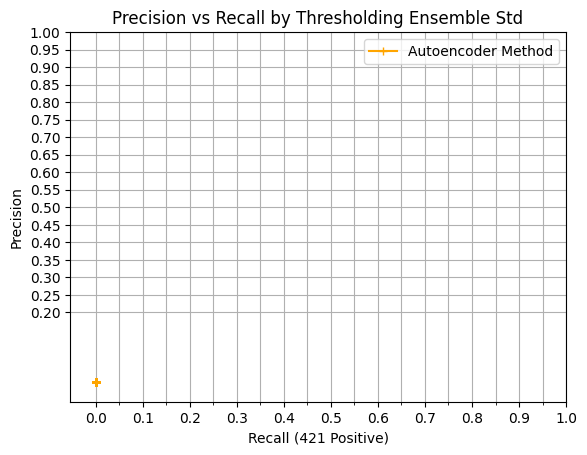

In [110]:
threshs = sp_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20) # Diff std. dev. thresholds (20 of them in this case)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs] # Portion of instances rejected @ each std threshold
accus = [np.mean((ext_preds==external_Y)[(threshs<=s)]) for s in std_threshs] # Acc @ each std thresh.
tps = [np.sum(((external_Y)*(ext_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ext_preds)*(ext_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.2, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Autoencoder Method'])

In [127]:
print(accus)

[1.0, 0.8571428571428571, 0.8536585365853658, 0.7857142857142857, 0.81, 0.7898550724637681, 0.7909604519774012, 0.7813953488372093, 0.7649402390438247, 0.738831615120275, 0.7284345047923323, 0.7308781869688386, 0.7222222222222222, 0.7126696832579186, 0.7034764826175869, 0.6950998185117967, 0.6829268292682927, 0.6651917404129793, 0.6557591623036649, 0.6211312700106724]


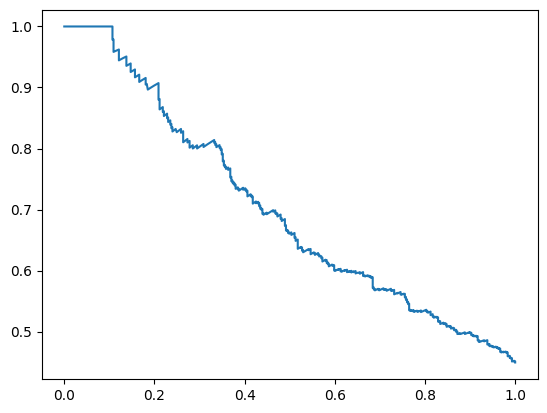

In [140]:
from sklearn.metrics import precision_recall_curve
p, r, thres = precision_recall_curve(external_Y, ext_preds)

plt.plot(r, p)

In [141]:
from sklearn.metrics import precision_recall_curve, auc

In [144]:
auc(r[r<0.2], p[r<0.2]) / np.max(r[r<0.2])

0.9670373318045292